In [1]:
import os
import scipy.io as sio
from os import listdir
from skimage import io
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange
import math   
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import scipy.io as sio
from os import listdir
from skimage import io
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange
import math   
import numpy as np
import matplotlib.pyplot as plt

# Install Data as it is saved from MATLAB and used in the Hybrid Case, 3 class classifier

NumPerElement=20000*3

im=torch.zeros(NumPerElement,1,128,40)
label=torch.zeros(NumPerElement)

count1=0
count=-1
folder_dir ='/Users/anuraagthakur/Desktop/MixedFSK16'
for images in os.listdir(folder_dir):
    if images != '.DS_Store':
        #print(images)
        AA=sio.loadmat(folder_dir+'/'+images)
        if(count1<NumPerElement):
            if(count1<20000):
                count1=count1+1
                count=count+1
                for key, value in AA.items():
                    im[count,0:1,0:128,0:40] = torch.from_numpy(abs(value))
                label[count]=0

            
folder_dir ='/Users/anuraagthakur/Desktop/FSK16'
count2=0
for images in os.listdir(folder_dir):
    if images != '.DS_Store':
        #print(images)
        AA=sio.loadmat(folder_dir+'/'+images)
        if(count2<NumPerElement):
            if(count2<20000):
                count2=count2+1
                count=count+1
                for key, value in AA.items():
                    im[count,0:1,0:128,0:40] = torch.from_numpy(abs(value))
                label[count]=1

        
folder_dir ='/Users/anuraagthakur/Desktop/MixedWideBand'
count3=0
for images in os.listdir(folder_dir):
    if images != '.DS_Store':
        #print(images)
        AA=sio.loadmat(folder_dir+'/'+images)
        if(count3<NumPerElement):
            if(count3<20000):
                count3=count3+1
                count=count+1
                for key, value in AA.items():
                    Image1=torch.from_numpy(abs(value))
                    im[count,0:1,0:128,0:40] = Image1[:,0:40]
                label[count]=2
            
               

In [3]:
print(count1,count2,count3)
print(label)

from sklearn.utils import shuffle
im, label = shuffle(im, label, random_state=0)
print(count1,count2,count3)
print(label)
print(count)

20000 20000 20000
tensor([0., 0., 0.,  ..., 2., 2., 2.])
20000 20000 20000
tensor([0., 0., 2.,  ..., 2., 2., 0.])
59999


In [4]:
conda install -c pytorch pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
conda install pytorch torchvision -c pytorch

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.4.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm, trange
import math   
import numpy as np
import matplotlib.pyplot as plt

In [7]:

class MultiHeadSelfAttention(nn.Module):
# Uses the Dot Product to determine the correlation and this determines the level of similarity
    def __init__(self, d, NumberHeadsGiven):
        super(MultiHeadSelfAttention, self).__init__()
        self.d = d
        self.NumberHeadsGivenLocal = NumberHeadsGiven

        d_head = int(d / NumberHeadsGiven)
           # mapping for query key and value is here from the open source transformer code I mentioned in the paper itself
        self.q_mappingSelf = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.NumberHeadsGivenLocal)]
        )
        self.k_mappingSelf = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.NumberHeadsGivenLocal)]
        )
        self.v_mappingsSelf = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.NumberHeadsGivenLocal)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward (self, GivenSequence):
        ResultofAttentionandValue = []
        for sequence in GivenSequence:
            seq_ResultofAttentionandValue = []
            for head in range(self.NumberHeadsGivenLocal):
                q_mapping = self.q_mappingSelf[head]
                k_mapping = self.k_mappingSelf[head]
                v_mapping = self.v_mappingsSelf[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5)) # Attention Dot product
                seq_ResultofAttentionandValue.append(attention @ v) # Attention times value
            ResultofAttentionandValue.append(torch.hstack(seq_ResultofAttentionandValue))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in ResultofAttentionandValue])

In [8]:
class VisionTransformer(nn.Module):
    def __init__(self, Hidden_DGiven, NumberHeadsGiven, HiddenMLPMultiplier=2): # Changed Ratio to 2/4 in different experiments
        super(VisionTransformer, self).__init__()
        self.Hidden_DGivenLocal= Hidden_DGiven
        self.NumberHeadsGivenLocal = NumberHeadsGiven

        self.normComp1 = nn.LayerNorm(Hidden_DGiven)
        self.mhsa = MultiHeadSelfAttention(Hidden_DGiven, NumberHeadsGiven)
        self.normComp2 = nn.LayerNorm(Hidden_DGiven)
        self.mlp = nn.Sequential(
            nn.Linear(Hidden_DGiven, HiddenMLPMultiplier * Hidden_DGiven),
            nn.GELU(), # Did some experiments here too but not much of a change
            nn.Linear(HiddenMLPMultiplier * Hidden_DGiven, Hidden_DGiven),
            )

    def forward(self, x):
        output = x + self.mhsa(self.normComp1(x)) # Residual Connection
        output = output + self.mlp(self.normComp2(output)) # Residual Connection
        return output

In [9]:
def get_positional_embeddings1(seq_len, d):
    resultingOutput = torch.ones(seq_len, d)
    for i in range(seq_len):
        for j in range(d):
            resultingOutput[i][j] = np.sin(i / (10000 ** (2*j / d))) if j % 2 == 0 else np.cos(i / (10000 ** (2*(j - 1) / d)))
    return resultingOutput

def get_positional_embeddings2(seq_len, d):
    resultingOutput = torch.ones(seq_len, d)
    for i in range(seq_len):
        for j in range(d):
            resultingOutput[i][j] = np.sin(i / (10000 ** (0.4*j / d))) if j % 2 == 0 else np.cos(i / (10000 ** (0.4*(j - 1) / d)))
    return resultingOutput

def get_positional_embeddings3(seq_len, d):
    resultingOutput = torch.ones(seq_len, d)
    for i in range(seq_len):
        for j in range(d):
            resultingOutput[i][j] = np.sin(i / (10000 ** (1*j / d))) if j % 2 == 0 else np.cos(i / (10000 ** (1*(j - 1) / d)))
    return resultingOutput

import math
def get_positional_embeddings4(seq_len, d):
    resultingOutput = torch.ones(seq_len, d)
    for i in range(seq_len):
        for j in range(d):
            resultingOutput[i][j] = np.sin(i / (10000 ** (3*math.sqrt(j) / (d)))) if j % 2 == 0 else np.cos(i / (10000 ** (3*math.sqrt(j - 1) / (d))))
    return resultingOutput

import math
def get_positional_embeddings5(seq_len, d):
    resultingOutput = torch.ones(seq_len, d)
    for i in range(seq_len):
        for j in range(d):
            resultingOutput[i][j] = (torch.tensor(np.sin(i / (10000 ** (math.sqrt(j) / (d)))) if j % 2 == 0 else np.cos(i / (10000 ** (math.sqrt(j - 1) / (d))))))
    return resultingOutput

torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])
torch.Size([50, 32])


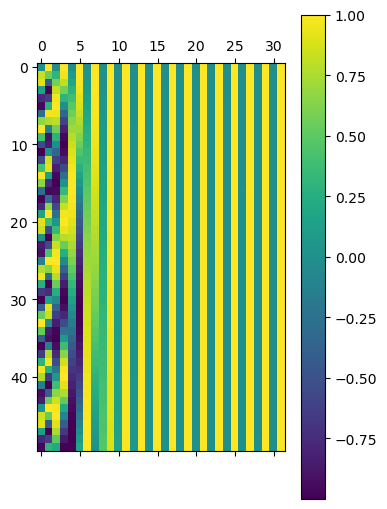

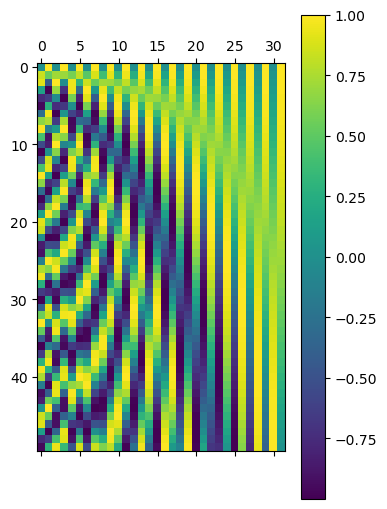

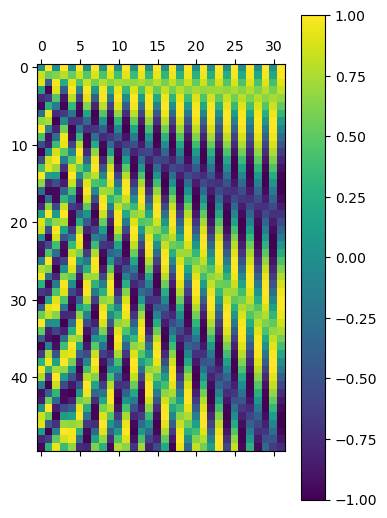

In [10]:
Index=50
Index2=32

P = get_positional_embeddings1(Index, Index2)
Plotter = plt.matshow(P)
plt.gcf().colorbar(Plotter)
print(P.shape)
Sum=[]
Var=[]
for i in range(Index):
    Sum.append(sum(P[1,0:Index2]*P[i,0:Index2]));
    Var.append(i)
    
    

P = get_positional_embeddings2(Index, Index2)
Plotter = plt.matshow(P)
plt.gcf().colorbar(Plotter)
print(P.shape)
for i in range(Index):
    Sum.append(sum(P[1,0:Index2]*P[i,0:Index2]));
    Var.append(i)
    
    

P = get_positional_embeddings3(Index, Index2)
Plotter = plt.matshow(P)
plt.gcf().colorbar(Plotter)
print(P.shape)
for i in range(Index):
    Sum.append(sum(P[1,0:Index2]*P[i,0:Index2]));
    Var.append(i)
    
    

P = get_positional_embeddings4(Index, Index2)
Plotter = plt.matshow(P)
plt.gcf().colorbar(Plotter)
print(P.shape)
for i in range(Index):
    Sum.append(sum(P[1,0:Index2]*P[i,0:Index2]));
    Var.append(i)
    
    
    
P = get_positional_embeddings5(Index, Index2)
Plotter = plt.matshow(P)
plt.gcf().colorbar(Plotter)
print(P.shape)
for i in range(Index):
    Sum.append(sum(P[1,0:Index2]*P[i,0:Index2]));
    Var.append(i)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

xpoints = np.array(Sum)
ypoints = np.array(Var)


plt.plot(ypoints[0:Index],xpoints[0:Index], 'g')
plt.plot(ypoints[0:Index],xpoints[Index:2*Index],'b')
plt.plot(ypoints[0:Index],xpoints[2*Index:3*Index], 'r')
plt.plot(ypoints[0:Index],xpoints[3*Index:4*Index], 'k')
plt.plot(ypoints[0:Index],xpoints[4*Index:5*Index], 'y')

plt.show()

In [12]:
#Split into trian and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(im, label, test_size=0.2, random_state=42)

print(X_train.size())
print(X_test.size())
print(y_train.size())
print(y_test.size())

Length=48000
Stride=2000

torch.Size([48000, 1, 128, 40])
torch.Size([12000, 1, 128, 40])
torch.Size([48000])
torch.Size([12000])


In [13]:
import math
class MyViT(nn.Module):
    def __init__(self, Dimensions, number_patchesRow,number_patchesColumn, number_blocks, Hidden_DGiven, NumberHeadsGiven, output_dimension):
        # This patches up the image in user specified coumn and row patches        
        super(MyViT, self).__init__()
        self.Dimensions = Dimensions  
        self.number_patchesRow = number_patchesRow
        self.number_patchesColumn=number_patchesColumn
        self.number_blocks = number_blocks
        self.Hidden_DGiven= Hidden_DGiven
        self.NumberHeadsGiven = NumberHeadsGiven
        
        self.patch_size = (math.floor(Dimensions[1] / number_patchesRow), math.floor(Dimensions[2] / number_patchesColumn))
        
        self.input_d = int(Dimensions[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.Hidden_DGiven)

        self.class_token = nn.Parameter(torch.rand(1, self.Hidden_DGiven))

        self.register_buffer(
            "positional_embeddings1",
            get_positional_embeddings1(number_patchesRow*number_patchesColumn + 1, Hidden_DGiven),
            persistent=False,
        )
        
        self.blocksA = nn.ModuleList(
            [VisionTransformer(Hidden_DGiven, NumberHeadsGiven) for _ in range(number_blocks)]
        )

        self.mlp = nn.Sequential(nn.Linear(self.Hidden_DGiven, output_dimension), nn.Softmax(dim=-1)) # The mlp is the final step which uses softmax for multiclass classifier

    def forward(self, images):        
        n, c, h, w = images.shape
        patches1A = images[0:n,0,0:self.patch_size[0]*self.number_patchesRow,0:self.patch_size[1]*self.number_patchesColumn]#patchify(images, self.n_patches).to(self.positional_embeddings1.device)
        Size=64#(patches1A.size(1)*patches1A.size(2))/(self.number_patchesRow*self.number_patchesColumn)
        #print(Size)
        patches1=patches1A.reshape(n,self.number_patchesRow*self.number_patchesColumn,Size)
        
        tokens1 = self.linear_mapper(patches1)
        tokensa = torch.cat((self.class_token.expand(n, 1, -1), tokens1), dim=1)

        A    = tokensa

        for block in self.blocksA:
            A = block(A)
        
        output = torch.ones(n,self.Hidden_DGiven)
        
        output[0:n,self.Hidden_DGiven*0:self.Hidden_DGiven]  = A[:, 0]

        return self.mlp(output)


def main():
    
    transform = ToTensor()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyViT(
        (1, 128,40), number_patchesRow=16, number_patchesColumn=5, number_blocks=2, Hidden_DGiven=5, NumberHeadsGiven=5, output_dimension=3
    ).to(device)

    NUMBER_EPOCHS = 15
    LearningRate = 0.003

    # Training Data loop
    optimizer = Adam(model.parameters(), lr= LearningRate)
    criterion = CrossEntropyLoss()

    for epoch in trange(NUMBER_EPOCHS, desc="Training"):
        training_loss = 0.0
        for batch in range(0,Length,Stride):
            y = y_train[batch:batch+Stride]
            x = X_train[batch:batch+Stride,0:1,0:128,0:40]
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            
            loss = criterion(y_hat, y.type(torch.LongTensor))
            print(loss)
            training_loss += loss.detach().cpu().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch + 1}/{NUMBER_EPOCHS} loss: {training_loss:.2f}")

    # Testing loop with testing data
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        y = y_test
        x = X_test

        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y.type(torch.LongTensor))

        test_loss += loss.detach().cpu().item()

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
main()



Training:   0%|                                          | 0/15 [00:00<?, ?it/s]

tensor(1.0803, grad_fn=<NllLossBackward0>)
tensor(1.0795, grad_fn=<NllLossBackward0>)
tensor(1.0701, grad_fn=<NllLossBackward0>)
tensor(1.0586, grad_fn=<NllLossBackward0>)
tensor(1.0494, grad_fn=<NllLossBackward0>)
tensor(1.0466, grad_fn=<NllLossBackward0>)
tensor(1.0378, grad_fn=<NllLossBackward0>)
tensor(1.0286, grad_fn=<NllLossBackward0>)
tensor(1.0213, grad_fn=<NllLossBackward0>)
tensor(1.0193, grad_fn=<NllLossBackward0>)
tensor(1.0121, grad_fn=<NllLossBackward0>)
tensor(1.0062, grad_fn=<NllLossBackward0>)
tensor(1.0040, grad_fn=<NllLossBackward0>)
tensor(0.9881, grad_fn=<NllLossBackward0>)
tensor(0.9909, grad_fn=<NllLossBackward0>)
tensor(0.9815, grad_fn=<NllLossBackward0>)
tensor(0.9763, grad_fn=<NllLossBackward0>)
tensor(0.9698, grad_fn=<NllLossBackward0>)
tensor(0.9630, grad_fn=<NllLossBackward0>)
tensor(0.9583, grad_fn=<NllLossBackward0>)
tensor(0.9526, grad_fn=<NllLossBackward0>)
tensor(0.9432, grad_fn=<NllLossBackward0>)
tensor(0.9406, grad_fn=<NllLossBackward0>)
tensor(0.93

Training:   7%|██                             | 1/15 [05:58<1:23:39, 358.52s/it]

Epoch 1/15 loss: 24.11
tensor(0.9345, grad_fn=<NllLossBackward0>)
tensor(0.9219, grad_fn=<NllLossBackward0>)
tensor(0.9196, grad_fn=<NllLossBackward0>)
tensor(0.9082, grad_fn=<NllLossBackward0>)
tensor(0.9058, grad_fn=<NllLossBackward0>)
tensor(0.9107, grad_fn=<NllLossBackward0>)
tensor(0.8992, grad_fn=<NllLossBackward0>)
tensor(0.8902, grad_fn=<NllLossBackward0>)
tensor(0.8836, grad_fn=<NllLossBackward0>)
tensor(0.8849, grad_fn=<NllLossBackward0>)
tensor(0.8767, grad_fn=<NllLossBackward0>)
tensor(0.8709, grad_fn=<NllLossBackward0>)
tensor(0.8723, grad_fn=<NllLossBackward0>)
tensor(0.8515, grad_fn=<NllLossBackward0>)
tensor(0.8610, grad_fn=<NllLossBackward0>)
tensor(0.8502, grad_fn=<NllLossBackward0>)
tensor(0.8460, grad_fn=<NllLossBackward0>)
tensor(0.8382, grad_fn=<NllLossBackward0>)
tensor(0.8334, grad_fn=<NllLossBackward0>)
tensor(0.8332, grad_fn=<NllLossBackward0>)
tensor(0.8305, grad_fn=<NllLossBackward0>)
tensor(0.8177, grad_fn=<NllLossBackward0>)
tensor(0.8216, grad_fn=<NllLoss

Training:  13%|████▏                          | 2/15 [11:13<1:12:05, 332.76s/it]

Epoch 2/15 loss: 20.88
tensor(0.8229, grad_fn=<NllLossBackward0>)
tensor(0.8051, grad_fn=<NllLossBackward0>)
tensor(0.8054, grad_fn=<NllLossBackward0>)
tensor(0.7969, grad_fn=<NllLossBackward0>)
tensor(0.7975, grad_fn=<NllLossBackward0>)
tensor(0.8027, grad_fn=<NllLossBackward0>)
tensor(0.7914, grad_fn=<NllLossBackward0>)
tensor(0.7856, grad_fn=<NllLossBackward0>)
tensor(0.7818, grad_fn=<NllLossBackward0>)
tensor(0.7805, grad_fn=<NllLossBackward0>)
tensor(0.7755, grad_fn=<NllLossBackward0>)
tensor(0.7721, grad_fn=<NllLossBackward0>)
tensor(0.7722, grad_fn=<NllLossBackward0>)
tensor(0.7570, grad_fn=<NllLossBackward0>)
tensor(0.7736, grad_fn=<NllLossBackward0>)
tensor(0.7637, grad_fn=<NllLossBackward0>)
tensor(0.7550, grad_fn=<NllLossBackward0>)
tensor(0.7464, grad_fn=<NllLossBackward0>)
tensor(0.7464, grad_fn=<NllLossBackward0>)
tensor(0.7375, grad_fn=<NllLossBackward0>)
tensor(0.7406, grad_fn=<NllLossBackward0>)
tensor(0.7267, grad_fn=<NllLossBackward0>)
tensor(0.7307, grad_fn=<NllLoss

Training:  20%|██████▏                        | 3/15 [16:36<1:05:40, 328.36s/it]

Epoch 3/15 loss: 18.49
tensor(0.7193, grad_fn=<NllLossBackward0>)
tensor(0.7243, grad_fn=<NllLossBackward0>)
tensor(0.7305, grad_fn=<NllLossBackward0>)
tensor(0.7111, grad_fn=<NllLossBackward0>)
tensor(0.7145, grad_fn=<NllLossBackward0>)
tensor(0.7090, grad_fn=<NllLossBackward0>)
tensor(0.7076, grad_fn=<NllLossBackward0>)
tensor(0.6979, grad_fn=<NllLossBackward0>)
tensor(0.6944, grad_fn=<NllLossBackward0>)
tensor(0.6954, grad_fn=<NllLossBackward0>)
tensor(0.6850, grad_fn=<NllLossBackward0>)
tensor(0.6871, grad_fn=<NllLossBackward0>)
tensor(0.6816, grad_fn=<NllLossBackward0>)
tensor(0.6820, grad_fn=<NllLossBackward0>)
tensor(0.6706, grad_fn=<NllLossBackward0>)
tensor(0.6714, grad_fn=<NllLossBackward0>)
tensor(0.6630, grad_fn=<NllLossBackward0>)
tensor(0.6659, grad_fn=<NllLossBackward0>)
tensor(0.6538, grad_fn=<NllLossBackward0>)
tensor(0.6595, grad_fn=<NllLossBackward0>)
tensor(0.6549, grad_fn=<NllLossBackward0>)
tensor(0.6492, grad_fn=<NllLossBackward0>)
tensor(0.6466, grad_fn=<NllLoss

Training:  27%|████████▎                      | 4/15 [22:27<1:01:52, 337.50s/it]

Epoch 4/15 loss: 16.42
tensor(0.6395, grad_fn=<NllLossBackward0>)
tensor(0.6386, grad_fn=<NllLossBackward0>)
tensor(0.6336, grad_fn=<NllLossBackward0>)
tensor(0.6309, grad_fn=<NllLossBackward0>)
tensor(0.6296, grad_fn=<NllLossBackward0>)
tensor(0.6278, grad_fn=<NllLossBackward0>)
tensor(0.6334, grad_fn=<NllLossBackward0>)
tensor(0.6209, grad_fn=<NllLossBackward0>)
tensor(0.6311, grad_fn=<NllLossBackward0>)
tensor(0.6231, grad_fn=<NllLossBackward0>)
tensor(0.6292, grad_fn=<NllLossBackward0>)
tensor(0.6189, grad_fn=<NllLossBackward0>)
tensor(0.6200, grad_fn=<NllLossBackward0>)
tensor(0.6231, grad_fn=<NllLossBackward0>)
tensor(0.6179, grad_fn=<NllLossBackward0>)
tensor(0.6108, grad_fn=<NllLossBackward0>)
tensor(0.6129, grad_fn=<NllLossBackward0>)
tensor(0.6088, grad_fn=<NllLossBackward0>)
tensor(0.6051, grad_fn=<NllLossBackward0>)
tensor(0.6112, grad_fn=<NllLossBackward0>)
tensor(0.6080, grad_fn=<NllLossBackward0>)
tensor(0.6045, grad_fn=<NllLossBackward0>)
tensor(0.6057, grad_fn=<NllLoss

Training:  33%|███████████                      | 5/15 [28:22<57:17, 343.78s/it]

Epoch 5/15 loss: 14.89
tensor(0.5995, grad_fn=<NllLossBackward0>)
tensor(0.6057, grad_fn=<NllLossBackward0>)
tensor(0.6010, grad_fn=<NllLossBackward0>)
tensor(0.6013, grad_fn=<NllLossBackward0>)
tensor(0.5972, grad_fn=<NllLossBackward0>)
tensor(0.5992, grad_fn=<NllLossBackward0>)
tensor(0.6041, grad_fn=<NllLossBackward0>)
tensor(0.5965, grad_fn=<NllLossBackward0>)
tensor(0.6059, grad_fn=<NllLossBackward0>)
tensor(0.5998, grad_fn=<NllLossBackward0>)
tensor(0.6057, grad_fn=<NllLossBackward0>)
tensor(0.5953, grad_fn=<NllLossBackward0>)
tensor(0.6007, grad_fn=<NllLossBackward0>)
tensor(0.6007, grad_fn=<NllLossBackward0>)
tensor(0.5980, grad_fn=<NllLossBackward0>)
tensor(0.5906, grad_fn=<NllLossBackward0>)
tensor(0.5947, grad_fn=<NllLossBackward0>)
tensor(0.5923, grad_fn=<NllLossBackward0>)
tensor(0.5897, grad_fn=<NllLossBackward0>)
tensor(0.5960, grad_fn=<NllLossBackward0>)
tensor(0.5934, grad_fn=<NllLossBackward0>)
tensor(0.5884, grad_fn=<NllLossBackward0>)
tensor(0.5907, grad_fn=<NllLoss

Training:  40%|█████████████▏                   | 6/15 [33:50<50:45, 338.37s/it]

Epoch 6/15 loss: 14.34
tensor(0.5861, grad_fn=<NllLossBackward0>)
tensor(0.5914, grad_fn=<NllLossBackward0>)
tensor(0.5908, grad_fn=<NllLossBackward0>)
tensor(0.5885, grad_fn=<NllLossBackward0>)
tensor(0.5853, grad_fn=<NllLossBackward0>)
tensor(0.5869, grad_fn=<NllLossBackward0>)
tensor(0.5911, grad_fn=<NllLossBackward0>)
tensor(0.5867, grad_fn=<NllLossBackward0>)
tensor(0.5924, grad_fn=<NllLossBackward0>)
tensor(0.5903, grad_fn=<NllLossBackward0>)
tensor(0.5911, grad_fn=<NllLossBackward0>)
tensor(0.5872, grad_fn=<NllLossBackward0>)
tensor(0.5899, grad_fn=<NllLossBackward0>)
tensor(0.5925, grad_fn=<NllLossBackward0>)
tensor(0.5881, grad_fn=<NllLossBackward0>)
tensor(0.5846, grad_fn=<NllLossBackward0>)
tensor(0.5875, grad_fn=<NllLossBackward0>)
tensor(0.5860, grad_fn=<NllLossBackward0>)
tensor(0.5830, grad_fn=<NllLossBackward0>)
tensor(0.5880, grad_fn=<NllLossBackward0>)
tensor(0.5840, grad_fn=<NllLossBackward0>)
tensor(0.5810, grad_fn=<NllLossBackward0>)
tensor(0.5851, grad_fn=<NllLoss

Training:  47%|███████████████▍                 | 7/15 [39:04<44:02, 330.27s/it]

Epoch 7/15 loss: 14.10
tensor(0.5821, grad_fn=<NllLossBackward0>)
tensor(0.5846, grad_fn=<NllLossBackward0>)
tensor(0.5943, grad_fn=<NllLossBackward0>)
tensor(0.5841, grad_fn=<NllLossBackward0>)
tensor(0.5882, grad_fn=<NllLossBackward0>)
tensor(0.5841, grad_fn=<NllLossBackward0>)
tensor(0.5888, grad_fn=<NllLossBackward0>)
tensor(0.5816, grad_fn=<NllLossBackward0>)
tensor(0.5870, grad_fn=<NllLossBackward0>)
tensor(0.5846, grad_fn=<NllLossBackward0>)
tensor(0.5805, grad_fn=<NllLossBackward0>)
tensor(0.5859, grad_fn=<NllLossBackward0>)
tensor(0.5830, grad_fn=<NllLossBackward0>)
tensor(0.5882, grad_fn=<NllLossBackward0>)
tensor(0.5819, grad_fn=<NllLossBackward0>)
tensor(0.5805, grad_fn=<NllLossBackward0>)
tensor(0.5834, grad_fn=<NllLossBackward0>)
tensor(0.5831, grad_fn=<NllLossBackward0>)
tensor(0.5797, grad_fn=<NllLossBackward0>)
tensor(0.5839, grad_fn=<NllLossBackward0>)
tensor(0.5788, grad_fn=<NllLossBackward0>)
tensor(0.5779, grad_fn=<NllLossBackward0>)
tensor(0.5803, grad_fn=<NllLoss

Training:  53%|█████████████████▌               | 8/15 [44:22<38:04, 326.35s/it]

Epoch 8/15 loss: 14.01
tensor(0.5780, grad_fn=<NllLossBackward0>)
tensor(0.5862, grad_fn=<NllLossBackward0>)
tensor(0.5866, grad_fn=<NllLossBackward0>)
tensor(0.5857, grad_fn=<NllLossBackward0>)
tensor(0.5760, grad_fn=<NllLossBackward0>)
tensor(0.5832, grad_fn=<NllLossBackward0>)
tensor(0.5786, grad_fn=<NllLossBackward0>)
tensor(0.5794, grad_fn=<NllLossBackward0>)
tensor(0.5820, grad_fn=<NllLossBackward0>)
tensor(0.5819, grad_fn=<NllLossBackward0>)
tensor(0.5834, grad_fn=<NllLossBackward0>)
tensor(0.5823, grad_fn=<NllLossBackward0>)
tensor(0.5843, grad_fn=<NllLossBackward0>)
tensor(0.5821, grad_fn=<NllLossBackward0>)
tensor(0.5790, grad_fn=<NllLossBackward0>)
tensor(0.5753, grad_fn=<NllLossBackward0>)
tensor(0.5785, grad_fn=<NllLossBackward0>)
tensor(0.5801, grad_fn=<NllLossBackward0>)
tensor(0.5754, grad_fn=<NllLossBackward0>)
tensor(0.5779, grad_fn=<NllLossBackward0>)
tensor(0.5796, grad_fn=<NllLossBackward0>)
tensor(0.5738, grad_fn=<NllLossBackward0>)
tensor(0.5772, grad_fn=<NllLoss

Training:  60%|███████████████████▊             | 9/15 [49:39<32:20, 323.38s/it]

Epoch 9/15 loss: 13.92
tensor(0.5729, grad_fn=<NllLossBackward0>)
tensor(0.5802, grad_fn=<NllLossBackward0>)
tensor(0.5751, grad_fn=<NllLossBackward0>)
tensor(0.5738, grad_fn=<NllLossBackward0>)
tensor(0.5716, grad_fn=<NllLossBackward0>)
tensor(0.5737, grad_fn=<NllLossBackward0>)
tensor(0.5754, grad_fn=<NllLossBackward0>)
tensor(0.5720, grad_fn=<NllLossBackward0>)
tensor(0.5777, grad_fn=<NllLossBackward0>)
tensor(0.5770, grad_fn=<NllLossBackward0>)
tensor(0.5754, grad_fn=<NllLossBackward0>)
tensor(0.5752, grad_fn=<NllLossBackward0>)
tensor(0.5765, grad_fn=<NllLossBackward0>)
tensor(0.5771, grad_fn=<NllLossBackward0>)
tensor(0.5733, grad_fn=<NllLossBackward0>)
tensor(0.5702, grad_fn=<NllLossBackward0>)
tensor(0.5739, grad_fn=<NllLossBackward0>)
tensor(0.5752, grad_fn=<NllLossBackward0>)
tensor(0.5722, grad_fn=<NllLossBackward0>)
tensor(0.5749, grad_fn=<NllLossBackward0>)
tensor(0.5710, grad_fn=<NllLossBackward0>)
tensor(0.5703, grad_fn=<NllLossBackward0>)
tensor(0.5706, grad_fn=<NllLoss

Training:  67%|█████████████████████▎          | 10/15 [55:15<27:16, 327.37s/it]

Epoch 10/15 loss: 13.78
tensor(0.5700, grad_fn=<NllLossBackward0>)
tensor(0.5764, grad_fn=<NllLossBackward0>)
tensor(0.5812, grad_fn=<NllLossBackward0>)
tensor(0.5765, grad_fn=<NllLossBackward0>)
tensor(0.5719, grad_fn=<NllLossBackward0>)
tensor(0.5749, grad_fn=<NllLossBackward0>)
tensor(0.5729, grad_fn=<NllLossBackward0>)
tensor(0.5727, grad_fn=<NllLossBackward0>)
tensor(0.5751, grad_fn=<NllLossBackward0>)
tensor(0.5762, grad_fn=<NllLossBackward0>)
tensor(0.5700, grad_fn=<NllLossBackward0>)
tensor(0.5763, grad_fn=<NllLossBackward0>)
tensor(0.5733, grad_fn=<NllLossBackward0>)
tensor(0.5781, grad_fn=<NllLossBackward0>)
tensor(0.5712, grad_fn=<NllLossBackward0>)
tensor(0.5714, grad_fn=<NllLossBackward0>)
tensor(0.5724, grad_fn=<NllLossBackward0>)
tensor(0.5750, grad_fn=<NllLossBackward0>)
tensor(0.5713, grad_fn=<NllLossBackward0>)
tensor(0.5745, grad_fn=<NllLossBackward0>)
tensor(0.5692, grad_fn=<NllLossBackward0>)
tensor(0.5698, grad_fn=<NllLossBackward0>)
tensor(0.5691, grad_fn=<NllLos

Training:  73%|██████████████████████        | 11/15 [1:00:43<21:50, 327.54s/it]

Epoch 11/15 loss: 13.76
tensor(0.5680, grad_fn=<NllLossBackward0>)
tensor(0.5762, grad_fn=<NllLossBackward0>)
tensor(0.5783, grad_fn=<NllLossBackward0>)
tensor(0.5759, grad_fn=<NllLossBackward0>)
tensor(0.5680, grad_fn=<NllLossBackward0>)
tensor(0.5756, grad_fn=<NllLossBackward0>)
tensor(0.5695, grad_fn=<NllLossBackward0>)
tensor(0.5724, grad_fn=<NllLossBackward0>)
tensor(0.5738, grad_fn=<NllLossBackward0>)
tensor(0.5760, grad_fn=<NllLossBackward0>)
tensor(0.5721, grad_fn=<NllLossBackward0>)
tensor(0.5770, grad_fn=<NllLossBackward0>)
tensor(0.5784, grad_fn=<NllLossBackward0>)
tensor(0.5748, grad_fn=<NllLossBackward0>)
tensor(0.5720, grad_fn=<NllLossBackward0>)
tensor(0.5693, grad_fn=<NllLossBackward0>)
tensor(0.5708, grad_fn=<NllLossBackward0>)
tensor(0.5734, grad_fn=<NllLossBackward0>)
tensor(0.5693, grad_fn=<NllLossBackward0>)
tensor(0.5693, grad_fn=<NllLossBackward0>)
tensor(0.5706, grad_fn=<NllLossBackward0>)
tensor(0.5660, grad_fn=<NllLossBackward0>)
tensor(0.5705, grad_fn=<NllLos

Training:  80%|████████████████████████      | 12/15 [1:05:45<15:59, 319.94s/it]

Epoch 12/15 loss: 13.74
tensor(0.5660, grad_fn=<NllLossBackward0>)
tensor(0.5679, grad_fn=<NllLossBackward0>)
tensor(0.5681, grad_fn=<NllLossBackward0>)
tensor(0.5657, grad_fn=<NllLossBackward0>)
tensor(0.5657, grad_fn=<NllLossBackward0>)
tensor(0.5669, grad_fn=<NllLossBackward0>)
tensor(0.5674, grad_fn=<NllLossBackward0>)
tensor(0.5656, grad_fn=<NllLossBackward0>)
tensor(0.5706, grad_fn=<NllLossBackward0>)
tensor(0.5705, grad_fn=<NllLossBackward0>)
tensor(0.5658, grad_fn=<NllLossBackward0>)
tensor(0.5687, grad_fn=<NllLossBackward0>)
tensor(0.5686, grad_fn=<NllLossBackward0>)
tensor(0.5692, grad_fn=<NllLossBackward0>)
tensor(0.5676, grad_fn=<NllLossBackward0>)
tensor(0.5636, grad_fn=<NllLossBackward0>)
tensor(0.5683, grad_fn=<NllLossBackward0>)
tensor(0.5676, grad_fn=<NllLossBackward0>)
tensor(0.5675, grad_fn=<NllLossBackward0>)
tensor(0.5675, grad_fn=<NllLossBackward0>)
tensor(0.5650, grad_fn=<NllLossBackward0>)
tensor(0.5638, grad_fn=<NllLossBackward0>)
tensor(0.5645, grad_fn=<NllLos

Training:  87%|██████████████████████████    | 13/15 [1:10:52<10:31, 315.97s/it]

Epoch 13/15 loss: 13.61
tensor(0.5650, grad_fn=<NllLossBackward0>)
tensor(0.5659, grad_fn=<NllLossBackward0>)
tensor(0.5733, grad_fn=<NllLossBackward0>)
tensor(0.5652, grad_fn=<NllLossBackward0>)
tensor(0.5715, grad_fn=<NllLossBackward0>)
tensor(0.5651, grad_fn=<NllLossBackward0>)
tensor(0.5700, grad_fn=<NllLossBackward0>)
tensor(0.5650, grad_fn=<NllLossBackward0>)
tensor(0.5730, grad_fn=<NllLossBackward0>)
tensor(0.5683, grad_fn=<NllLossBackward0>)
tensor(0.5654, grad_fn=<NllLossBackward0>)
tensor(0.5670, grad_fn=<NllLossBackward0>)
tensor(0.5733, grad_fn=<NllLossBackward0>)
tensor(0.5693, grad_fn=<NllLossBackward0>)
tensor(0.5693, grad_fn=<NllLossBackward0>)
tensor(0.5620, grad_fn=<NllLossBackward0>)
tensor(0.5710, grad_fn=<NllLossBackward0>)
tensor(0.5667, grad_fn=<NllLossBackward0>)
tensor(0.5676, grad_fn=<NllLossBackward0>)
tensor(0.5657, grad_fn=<NllLossBackward0>)
tensor(0.5644, grad_fn=<NllLossBackward0>)
tensor(0.5621, grad_fn=<NllLossBackward0>)
tensor(0.5638, grad_fn=<NllLos

Training:  93%|████████████████████████████  | 14/15 [1:15:54<05:11, 311.60s/it]

Epoch 14/15 loss: 13.62
tensor(0.5659, grad_fn=<NllLossBackward0>)
tensor(0.5647, grad_fn=<NllLossBackward0>)
tensor(0.5730, grad_fn=<NllLossBackward0>)
tensor(0.5660, grad_fn=<NllLossBackward0>)
tensor(0.5721, grad_fn=<NllLossBackward0>)
tensor(0.5645, grad_fn=<NllLossBackward0>)
tensor(0.5708, grad_fn=<NllLossBackward0>)
tensor(0.5673, grad_fn=<NllLossBackward0>)
tensor(0.5668, grad_fn=<NllLossBackward0>)
tensor(0.5721, grad_fn=<NllLossBackward0>)
tensor(0.5639, grad_fn=<NllLossBackward0>)
tensor(0.5728, grad_fn=<NllLossBackward0>)
tensor(0.5654, grad_fn=<NllLossBackward0>)
tensor(0.5760, grad_fn=<NllLossBackward0>)
tensor(0.5659, grad_fn=<NllLossBackward0>)
tensor(0.5701, grad_fn=<NllLossBackward0>)
tensor(0.5647, grad_fn=<NllLossBackward0>)
tensor(0.5730, grad_fn=<NllLossBackward0>)
tensor(0.5642, grad_fn=<NllLossBackward0>)
tensor(0.5682, grad_fn=<NllLossBackward0>)
tensor(0.5643, grad_fn=<NllLossBackward0>)
tensor(0.5652, grad_fn=<NllLossBackward0>)
tensor(0.5628, grad_fn=<NllLos

Training: 100%|██████████████████████████████| 15/15 [1:21:41<00:00, 326.74s/it]

Epoch 15/15 loss: 13.63


Test loss: 0.56
Test accuracy: 99.02%
